<a href="https://colab.research.google.com/github/kluless13/R-test/blob/main/urchin_v_starfish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Pipeline

In [1]:
!nvidia-smi

Mon May 29 01:28:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 1.1 Installing major dependencies

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

#### 1.2 Fixing OOM error possibilities

In [3]:
# OOM errors are out of memory errors
# We prevent this by making sure the GPU is intact for the model

gpus = tf.config.experimental.list_physical_devices('GPU')
len(gpus)

# There is 1 GPU present.

1

In [5]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# We make sure the memory functions are the GPU's responsibility. 

In [6]:
# Confirming memory location

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 1.3 Removing weak images

In [7]:
# Making sure the images are of good quality by scraping out the formats we have not specified.

data_dir = '/content/drive/MyDrive/urchin_v_starfish'

image_exts = ['jpeg','jpg','bmp','png'] # No svgs or vector type images

In [9]:
# A for loop that removes what we don't require.

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/28715473.jpg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector2.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/192px.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector12.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector8.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector9.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector4.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector11.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector13.svg
Image not in ext list /content/drive/MyDrive/urchin_v_starfish/starfish_images/vector3.sv

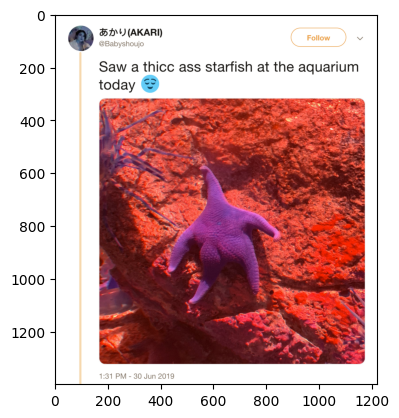

In [10]:
a = cv2.imread(os.path.join('/content/drive/MyDrive/urchin_v_starfish','starfish_images','/content/drive/MyDrive/diadema vs starfish/starfish/0e3bb238-6ce5-40e9-943a-6517f2fb5696-Screen_Shot_2019-07-02_at_4.05.07_PM.png'))
plt.imshow(a)

#### 1.4 Load Data for model training

In [11]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 510 files belonging to 2 classes.


In [12]:
# There are 2 classes, starfish and sea urchins.

# We now iterate our image classes.

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
# We now have iterating batches.

In [13]:
# This is how the image will be represented as numpy arrays.

batch[0].shape

(32, 256, 256, 3)

In [14]:
batch[1]
# Class 0 are starfish and class 1 are urchins. In the first batch, the 0's and 1's represent the classes.

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1], dtype=int32)

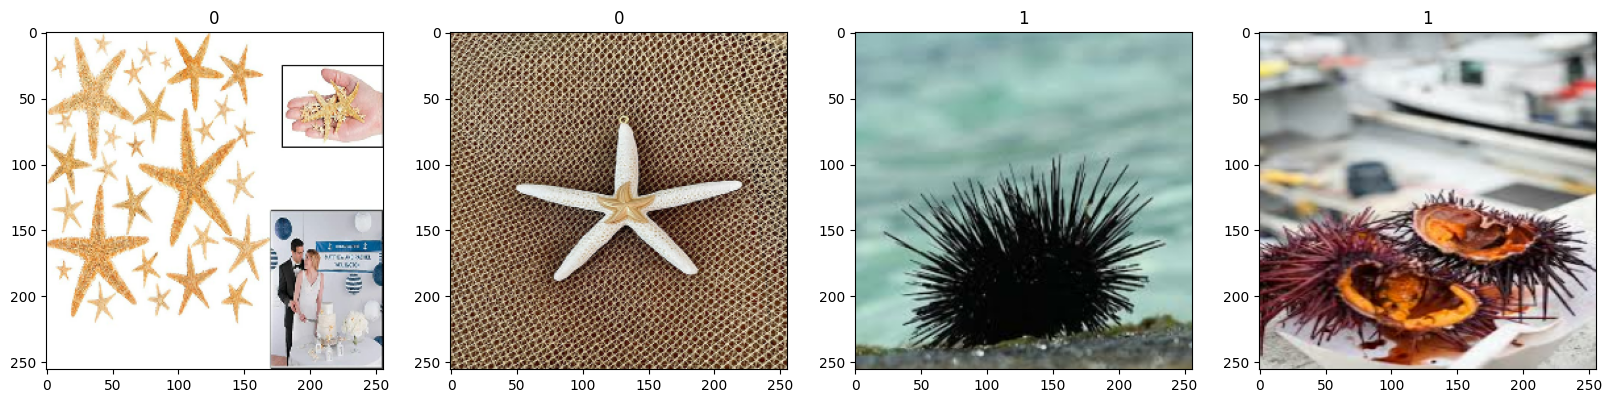

In [15]:
# We can observe this as well

fig, ax = plt.subplots(ncols=4, figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### 2. Pre-process Data

#### 2.1 Scale data

In [16]:
data = data.map(lambda x, y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()

In [18]:
# We can see the minimum and maximum values of the scaled images. 
# Minimum must be 0 and maximum must be 1.

scaled_iterator.next()[0].min()

0.0

In [19]:
scaled_iterator.next()[0].max()

1.0

#### 2.2 Split data

In [20]:
len(data)

16

In [21]:
train_size = int(len(data)*.7) # 70%
val_size = int(len(data)*.2) # 20%
test_size = int(len(data)*.1) # 10%

In [22]:
# Using train and skip features from Tensorflow
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### 3. Machine Learning model

#### 3.1 Model Dependencies

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3),1, activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Explanation of code:

The provided code describes the architecture of a Convolutional Neural Network (CNN) using Keras, a high-level neural networks API that runs on top of TensorFlow. This model is commonly used for image classification tasks. Here is a breakdown of the code:

1. `model = Sequential()`: This line initializes a linear stack of layers that you can add to one by one. The Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

2. `model.add(Conv2D(16, (3,3),1, activation = 'relu', input_shape=(256,256,3)))`: This line adds a 2D convolutional layer to the model. This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. The parameters specify 16 filters, a kernel size of 3x3, a stride of 1, and a Rectified Linear Unit (ReLU) activation function. The `input_shape=(256,256,3)` indicates that the input images are 256 pixels by 256 pixels with 3 color channels (RGB).

3. `model.add(MaxPooling2D())`: This line adds a 2D max pooling layer. Max pooling is a downsampling strategy that looks at 2x2 patches of the input (by default) and outputs the max value in each patch. This helps to reduce the spatial dimensions (width, height) of the input volume for the next convolutional layer.

4. The next series of `Conv2D` and `MaxPooling2D` layers follow a similar pattern: they apply further convolutions and downsampling to learn more complex features from the input data.

5. `model.add(Flatten())`: This line flattens the input. It does not affect the batch size. This means it takes the 3D output of the previous layer (height, width, filters) and flattens it into a 1D array. This is necessary because fully connected layers (like the ones that follow) expect 1D input.

6. `model.add(Dense(256,activation='relu'))`: This line adds a fully connected (dense) layer with 256 neurons. Each neuron will take the input from all the neurons in the previous layer, apply a weight, add a bias, and then pass the sum through a ReLU activation function.

7. `model.add(Dense(1,activation='sigmoid'))`: This line adds the output layer of the network. It's a dense layer with a single neuron because this model is presumably for binary classification (two classes). The neuron will output a value between 0 and 1, thanks to the sigmoid activation function, representing the predicted probability of the positive class.

8. `model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])`: This line compiles the model with the Adam optimization algorithm, a binary cross-entropy loss function (which is appropriate for binary classification problems), and it will track accuracy as a metric during training.

#### 3.2 Training the model

In [28]:
logdir = '/content/drive/MyDrive/urchin_v_starfish/logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 17s 399ms/step - loss: 1.0379 - accuracy: 0.5795 - val_loss: 0.6700 - val_accuracy: 0.6354
Epoch 2/20
11/11 [==============================] - 6s 466ms/step - loss: 0.6339 - accuracy: 0.6477 - val_loss: 0.6186 - val_accuracy: 0.6042
Epoch 3/20
11/11 [==============================] - 6s 488ms/step - loss: 0.5623 - accuracy: 0.6733 - val_loss: 0.4987 - val_accuracy: 0.7083
Epoch 4/20
11/11 [==============================] - 6s 494ms/step - loss: 0.5399 - accuracy: 0.6562 - val_loss: 0.5338 - val_accuracy: 0.7083
Epoch 5/20
11/11 [==============================] - 7s 561ms/step - loss: 0.5110 - accuracy: 0.6790 - val_loss: 0.4944 - val_accuracy: 0.8229
Epoch 6/20
11/11 [==============================] - 7s 539ms/step - loss: 0.4754 - accuracy: 0.6960 - val_loss: 0.3875 - val_accuracy: 0.7604
Epoch 7/20
11/11 [==============================] - 7s 478ms/step - loss: 0.3809 - accuracy: 0.8125 - val_loss: 0.3687 - val_accuracy: 0.7917
Epoch

Explanation of code:

- `model.fit()`: This is a method for training the model for a fixed number of epochs (iterations on a dataset). It's a core method of Keras models.

- `train`: This is the training data which the model will learn from. The data should be formatted as a tuple `(inputs, targets)` where `inputs` is the training data and `targets` are the corresponding labels.

- `epochs=20`: This specifies the number of epochs, or iterations over the entire dataset, to train for. In this case, the model will be trained for 20 epochs.

- `validation_data=val`: This is the data that will be used to evaluate the loss and any model metrics at the end of each epoch. The model will not learn from this data. This argument can be a tuple `(inputs, targets)` or a tf.data.Dataset. The `val` variable should contain the validation data.

- `callbacks=[tensorboard_callback]`: This argument takes a list of functions, called callbacks, that are applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. In this case, the `tensorboard_callback` is likely a TensorBoard callback that was defined earlier in your code. TensorBoard is a visualization tool provided with TensorFlow for understanding, debugging and optimizing the model training process. It uses summary events that are written while you're running your graph.

- `hist =`: The `fit` function returns a `History` object. Its `History.history` attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable). By assigning the result of `fit` to `hist`, you're saving these values so you can plot or analyze them later.

*This line of code is training the model on the provided training data for 20 epochs, evaluating it on the validation data after each epoch, and storing the training history for later analysis, while also logging information for visualization in TensorBoard.*

#### 3.3 Plotting performance

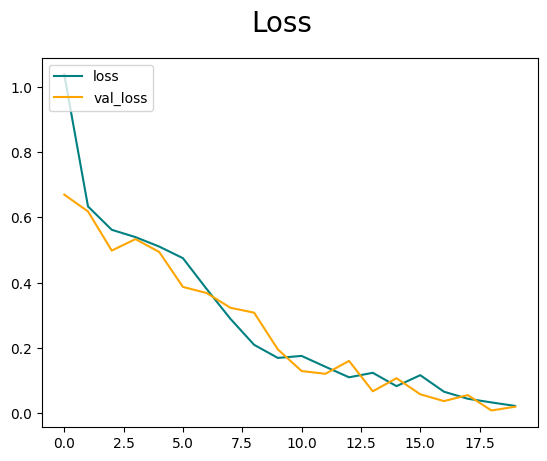

In [31]:
#Plotting loss

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

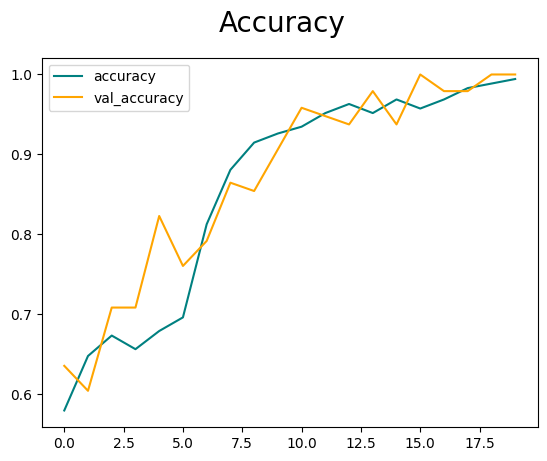

In [32]:
# Plotting accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 4. Evaluating performance

#### 4.1 Getting evaluation dependencies

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 117ms/step


In [36]:
# Evaluation metrics

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


Seems too good to be true, but that's because we have overfit the model.

This can be solved by increasing the data set.

#### 4.2 Tests

#### 4.2.1 Starfish test

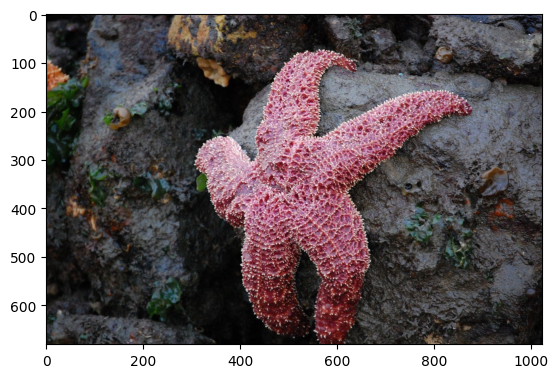

In [42]:
# Acquiring an image from a different distribution

img = cv2.imread('/content/drive/MyDrive/diadema vs starfish/starfish/35AB6249-96A4-458A-A2AAFAA3E06991F2_source.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

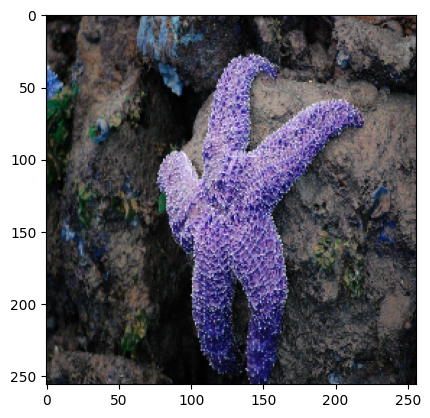

In [43]:
# Resizing the image

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 19ms/step


In [45]:
yhat

array([[0.99676263]], dtype=float32)

In [46]:
if yhat > 0.5:
  print(f'Predicted class is Starfish')
else:
  print(f'Predicted class is Didema')

Predicted class is Starfish


#### 4.2.2 Urchin test

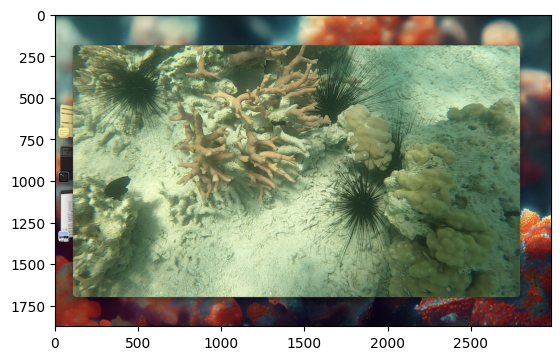

In [62]:
img1 = cv2.imread('/content/drive/MyDrive/angad - food /diadema_test.jpeg')
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

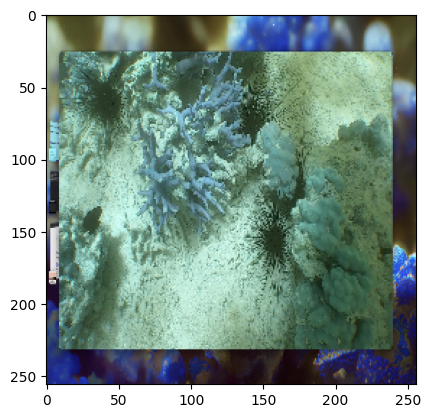

In [63]:
resize1 = tf.image.resize(img1, (256,256))
plt.imshow(resize1.numpy().astype(int))
plt.show()

In [64]:
yhat1 = model.predict(np.expand_dims(resize1/255,0))

1/1 [==============================] - 0s 26ms/step


In [65]:
yhat1

array([[0.0359746]], dtype=float32)

In [67]:
if yhat1 > 0.5:
  print(f'Predicted class is Starfish')
else:
  print(f'Predicted class is Urchin')

Predicted class is Urchin


### 5. Saving the model

In [68]:
from tensorflow.keras.models import load_model

In [69]:
models = '/content/drive/MyDrive/urchin_v_starfish/Models'
model.save(os.path.join(models,'urchin_v_starfish.h5'))